# Human-Mammalian Brain - Basal Ganglia 10X snRNASeq analysis: clustering and annotations

The basal ganglia (BG) are a system of interconnected brain structures that play a crucial role in motor control, learning, behavior, and emotion. With approximately 200 million neurons in the human basal ganglia alone, these structures are involved in a wide range of neurological processes and are implicated in numerous disorders affecting human health, including Parkinson’s disease, Huntington’s disease, and substance abuse disorders. To further understand the complexity of the basal ganglia, researchers have historically classified its neurons into various types based on their cytoarchitecture, connectivity, molecular profile, and functional properties. However, recent advancements in high-throughput transcriptomic profiling have revolutionized our ability to systematically categorize these cell types within species, while the maturation of machine learning technologies have enabled the integration of these taxonomies across species.

Our **consensus basal ganglia cell type taxonomy** is the result of iterative clustering and cross-species integration of transcriptomic data. The taxonomy encompasses neurons from key structures within the basal ganglia, including the caudate (Ca), putamen (Pu), nucleus accumbens (NAc), the external and internal segments of the globus pallidus (GPe, GPi), subthalamic nucleus (STN), and substantia nigra (SN). By combining data from multiple primate and rodent species, we have developed a consensus taxonomy that highlights both conserved and species-specific cell types. We validate our taxonomy through marker gene expression analysis, comparison with previously published taxonomies, and self-projection, ensuring the accuracy and robustness of each level in the taxonomic hierarchy.

You need to be connected to the internet to run this notebook or connected to a cache that has the HMBA-BG data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the  [``general_accessing_10x_snRNASeq_tutorial.ipynb``](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) tutorial/example. In a related tutorial, we also show how to access and use [HMBA-BG gene expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_10X_snRNASeq_tutorial.html).

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object downloads data requested by the user, tracks which files have already been downloaded to your local system, and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you would like to download the data in your system.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(
    download_base,
    s3_bucket='allen-brain-cell-atlas-staging',
    auth_required=True
)

abc_cache.current_manifest

'releases/20250630/manifest_updated_250828.json'

## Data overview

We'll quickly walk through the data we will be using in this notebook. The HMBA-BG 10X datasets are located across several directories listed in the `ABCProjectCache`. In this notebook, we will be looking at the Aligned HMBA-BG 10X dataset. These data combine the there species with an aligned set of ~16k across the species. We will be using data and metadata from the following directories:
- HMBA-10xMultiome-BG-Aligned
- HMBA-BG-taxonomy-CCN20250428

Note that data for each individual species is available in the directory `HMBA-10xMultiome-BG`.

Below we list the data and metadata in the HMBA-10xMultiome-BG-Aligned dataset.

In [3]:
print("HMBA-10xMultiome-BG-Aligned: gene expression data (h5ad)\n\t", abc_cache.list_expression_matrix_files(directory='HMBA-10xMultiome-BG-Aligned'))
print("HMBA-10xMultiome-BG-Aligned: metadata (csv)\n\t", abc_cache.list_metadata_files(directory='HMBA-10xMultiome-BG-Aligned'))

HMBA-10xMultiome-BG-Aligned: gene expression data (h5ad)
	 ['HMBA-10xMultiome-BG-Aligned/log2', 'HMBA-10xMultiome-BG-Aligned/raw']
HMBA-10xMultiome-BG-Aligned: metadata (csv)
	 ['cell_metadata', 'donor', 'example_gene_expression', 'gene', 'library', 'value_sets']


We will also use metadata from the HMBA-BG taxonomy directory. Below is the list of available files:

In [4]:
print("HMBA-BG-taxonomy-CCN20250428: metadata (csv)\n\t", abc_cache.list_metadata_files(directory='HMBA-BG-taxonomy-CCN20250428'))

HMBA-BG-taxonomy-CCN20250428: metadata (csv)
	 ['abbreviation_term', 'cell_2d_embedding_coordinates', 'cell_to_cluster_membership', 'cluster', 'cluster_annotation_term', 'cluster_annotation_term_set', 'cluster_annotation_to_abbreviation_map', 'cluster_to_cluster_annotation_membership']


### Cell metadata

Essential cell metadata is stored as a CSV file that we load as a Pandas DataFrame. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. This metadata file contains cells across all species in the HMBA-BG dataset.

Each cell is associated with a *library label*, *donor label*, *alignment_job_id*, *feature_matrix_label* and *dataset_label* identifying which data package this cell is part of. This metadata file will be combined with other metadata files that ship with this package to add information associated with the donor, UMAP coordinates, cluster assignments, and more.

Below, we load the first of the metadata used in this tutorial. This represents the cell metadata for the aligned dataset.

The command we use below both downloads the data if it is not already available in the local cache and loads the data as a Pandas DataFrame. This pattern of loading metadata is repeated throughout the tutorials.

In [5]:
cell = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='cell_metadata',
    dtype={'cell_label': str}
).set_index('cell_label')
print("Number of cells = ", len(cell))
cell.head()

/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:643: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


Number of cells =  1896133


cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027    15259.0   
AAACAGCCAATTGAGA-2362_A05       0.054795    20645.0   
AAACAGCCAGCATGTC-2362_A05       0.000000     2551.0   
AAACAGCCATTGACAT-2362_A05       0.000000     2341.0   
AAACAGCCATTGTGGC-2362_A05       0.027397     8326.0   

                                  feature_matrix_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                         dataset_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                                  abc_sample_id  
cell_label                                                       
AAACAGCCAAATGCCC-2362_A05  38447b19-a5dc-4eca-9021-56ae191e8809  
AAACAGCCAATTGAGA-2362_A05  3dc4dc1f-4b8a-4012-bb07-e3906ad70da0  
AAACAGCCAGCATGTC-2362_A05  291d6ebf-ca70-4d9d-8dde-10fa841dba93  
AAACAGCCATTGACAT-2362_A05  12153419-9b49-4d5f-a10d-ddb7837a729d  
AAACAGCCATTGTGGC-2362_A05  5716499d-d69d-489e-b4ed-6841b6ba051d

We can use pandas `groupby` function to see how many unique items are associated for each field and list them out if the number of unique items is small.

In [6]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [7]:
print_column_info(cell)

Number of unique cell_barcode = 680274 
Number of unique donor_label = 22 ['CJ23.56.002', 'CJ23.56.003', 'CJ24.56.001', 'CJ24.56.004', 'H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 417 
Number of unique library_label = 417 
Number of unique alignment_job_id = 303 
Number of unique doublet_score = 1422 
Number of unique umi_count = 85704 
Number of unique feature_matrix_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique abc_sample_id = 1863243 


### Donor and Library metadata

The first two associated metadata we load are the `donor` and `library` tables. The donor table contains species, sex, and age information. The library table contains information on 10X methods and brain region of interest the tissue was extracted from.

In [8]:
donor = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='donor'
).set_index('donor_label')
donor.head()

donor_species species_scientific_name species_genus donor_sex  \
donor_label                                                                   
QM23.50.003  NCBITaxon:9544          Macaca mulatta       Macaque      Male   
QM21.26.001  NCBITaxon:9544          Macaca mulatta       Macaque      Male   
Q19.26.010   NCBITaxon:9544          Macaca mulatta       Macaque    Female   
H24.30.003   NCBITaxon:9606            Homo sapiens         Human    Female   
H21.30.004   NCBITaxon:9606            Homo sapiens         Human      Male   

            donor_age  donor_age_value donor_age_unit donor_nhash_id  
donor_label                                                           
QM23.50.003     6 yrs              6.0          years    DO-HHOI8925  
QM21.26.001     6 yrs              6.0          years    DO-MCUM5797  
Q19.26.010     10 yrs             10.0          years    DO-XYBX6133  
H24.30.003     19 yrs             19.0          years    DO-OSUT8071  
H21.30.004     57 yrs             57.0          years    DO-XWIW2465

In [9]:
library = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='library'
).set_index('library_label')
library.head()

library_method library_nhash_id  \
library_label                                          
L8XR_240222_21_H03  10xMultiome;GEX  LI-LXVEUM541384   
L8XR_220428_02_A05  10xMultiome;GEX  LI-RNSEIM617503   
L8XR_220428_02_C04  10xMultiome;GEX  LI-IHJMHI295497   
L8XR_240705_01_A06  10xMultiome;GEX  LI-EBDPMM615369   
L8XR_240919_21_B05  10xMultiome;GEX  LI-GUPMNR700763   

                   barcoded_cell_sample_label  \
library_label                                   
L8XR_240222_21_H03                   2077_A02   
L8XR_220428_02_A05                   1224_A04   
L8XR_220428_02_C04                   1222_A02   
L8XR_240705_01_A06                   2305_E01   
L8XR_240919_21_B05                   2453_A02   

                                            enrichment_population  \
library_label                                                       
L8XR_240222_21_H03              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_220428_02_A05  10% NeuN+, 49% OLIG2-, 25% OLIG2+, 16% Nurr1+   
L8XR_220428_02_C04              60% NeuN+, 27% OLIG2-, 13% OLIG2+   
L8XR_240705_01_A06              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_240919_21_B05              70% NeuN+, 20% OLIG2-, 10% OLIG2+   

                   cell_specimen_type parcellation_term_identifier  \
library_label                                                        
L8XR_240222_21_H03             Nuclei                   DHBA:11538   
L8XR_220428_02_A05             Nuclei                   DHBA:12261   
L8XR_220428_02_C04             Nuclei                   DHBA:10466   
L8XR_240705_01_A06             Nuclei                   DHBA:11537   
L8XR_240919_21_B05             Nuclei                   DHBA:10345   

                   region_of_interest_name region_of_interest_label  \
library_label                                                         
L8XR_240222_21_H03          caudal putamen                      PuC   
L8XR_220428_02_A05  ventral tegmental area                      VTA   
L8XR_220428_02_C04     subthalamic nucleus                      STH   
L8XR_240705_01_A06         rostral putamen                      PuR   
L8XR_240919_21_B05        Ventral pallidus                      VeP   

                   anatomical_division_label  donor_label  \
library_label                                               
L8XR_240222_21_H03             Basal ganglia  QM23.50.003   
L8XR_220428_02_A05             Basal ganglia  QM21.26.001   
L8XR_220428_02_C04             Basal ganglia   Q19.26.010   
L8XR_240705_01_A06             Basal ganglia   H24.30.003   
L8XR_240919_21_B05             Basal ganglia   H21.30.004   

                   specimen_dissected_roi_label  \
library_label                                     
L8XR_240222_21_H03     QM23.50.003.CX.08.PuC.01   
L8XR_220428_02_A05       Q21.26.001.CX44.SN.001   
L8XR_220428_02_C04      Q19.26.010.CX42.STH.001   
L8XR_240705_01_A06      H24.30.003.CX.14.PuR.01   
L8XR_240919_21_B05      H21.30.004.CX.18.VEP.01   

                   specimen_dissected_roi_nhash_id         slab_label  \
library_label                                                           
L8XR_240222_21_H03                 RI-KHNKLI464991  QM23.50.003.CX.08   
L8XR_220428_02_A05                 RI-VYYVBV771518  QM21.26.001.CX.44   
L8XR_220428_02_C04                 RI-IMHMMG443226   Q19.26.010.CX.42   
L8XR_240705_01_A06                 RI-XZUAVY396052   H24.30.003.CX.14   
L8XR_240919_21_B05                 RI-XVBWXT892729   H21.30.004.CX.18   

                      slab_nhash_id  
library_label                        
L8XR_240222_21_H03  SL-HHOIKA892526  
L8XR_220428_02_A05  SL-MCUMVX579790  
L8XR_220428_02_C04  SL-XYBXSZ613335  
L8XR_240705_01_A06  SL-OSUTGV807183  
L8XR_240919_21_B05  SL-XWIWGI246585

We combine these into an extended cell metadata table.

In [10]:
cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(library, on='library_label', rsuffix='_library_table')

del cell

Below we use a pandas `groupby` to show the number of cells from each species.

In [11]:
cell_extended.groupby('species_genus')[['feature_matrix_label']].count()

feature_matrix_label
species_genus                      
Human                       1034819
Macaque                      548281
Marmoset                     313033

We can also use the `groupby` function to show the number of cells in each region of interest extracted from the BG.

In [12]:
cell_extended.groupby('region_of_interest_name')[['region_of_interest_label']].count()

region_of_interest_label
region_of_interest_name                                               
Ventral pallidus                                                 36512
body of caudate                                                 187160
brain                                                           313033
caudal putamen                                                  166106
caudate nucleus                                                  27672
core of nucleus accumbens                                        19192
external segment of globus pallidus                             204481
globus pallidus                                                   4567
head of caudate                                                 132071
internal segment of globus pallidus                             131680
nucleus accumbens                                               149878
peri-caudate ependymal and subependymal zone                      8376
posteroventral putamen                                           74232
putamen                                                          34951
rostral putamen                                                 196244
shell of nucleus accumbens                                        9385
substantia nigra                                                 33156
subthalamic nucleus                                              58570
tail of caudate                                                  87073
ventral tegmental area                                           21794

### Adding color and feature order

Each major feature in the donor and library table is associated with unique colors and an ordering with the set of values. Below we load the `value_sets` DataFrame which is a mapping from the various value in the donor and species tables to those colors and orderings. We incorporate these values into the cell metadata table. 

In [13]:
value_sets = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='value_sets'
).set_index('label')
value_sets.head()

table          field description  order external_identifier  \
label                                                                   
Female    donor      donor_sex      Female      1                 NaN   
Male      donor      donor_sex        Male      2                 NaN   
Human     donor  species_genus       Human      1     NCBITaxon:9605    
Macaque   donor  species_genus     Macaque      2     NCBITaxon:9539    
Marmoset  donor  species_genus    Marmoset      3      NCBITaxon:9481   

         parent_label color_hex_triplet  
label                                    
Female            NaN           #565353  
Male              NaN           #ADC4C3  
Human             NaN           #377eb8  
Macaque           NaN           #4daf4a  
Marmoset          NaN           #FF5F5D

We define a convince function to add colors for the various values in the data (e.g. unique region of interest or donor sex values).

In [14]:
def extract_value_set(cell_metadata_df: pd.DataFrame, input_value_set: pd.DataFrame, input_value_set_label: str):
    """Add color and order columns to the cell metadata dataframe based on the input
    value set.

    Columns are added as {input_value_set_label}_color and {input_value_set_label}_order.

    Parameters
    ----------
    cell_metadata_df : pd.DataFrame
        DataFrame containing cell metadata.
    input_value_set : pd.DataFrame
        DataFrame containing the value set information.
    input_value_set_label : str
        The the column name to extract color and order information for. will be added to the cell metadata.
    """
    cell_metadata_df[f'{input_value_set_label}_color'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['color_hex_triplet'].values
    cell_metadata_df[f'{input_value_set_label}_order'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['order'].values

Use our function to add the relevant color and order columns to our cell_metadata table.

In [15]:
# Add region of interest color and order
extract_value_set(cell_extended, value_sets, 'region_of_interest_label')
# Add species common name color and order
extract_value_set(cell_extended, value_sets, 'species_genus')
# Add species scientific name color and order
extract_value_set(cell_extended, value_sets, 'species_scientific_name')
# Add donor sex color and order
extract_value_set(cell_extended, value_sets, 'donor_sex')
cell_extended.head()

cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027    15259.0   
AAACAGCCAATTGAGA-2362_A05       0.054795    20645.0   
AAACAGCCAGCATGTC-2362_A05       0.000000     2551.0   
AAACAGCCATTGACAT-2362_A05       0.000000     2341.0   
AAACAGCCATTGTGGC-2362_A05       0.027397     8326.0   

                                  feature_matrix_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                         dataset_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                                  abc_sample_id  ...  \
cell_label                                                       ...   
AAACAGCCAAATGCCC-2362_A05  38447b19-a5dc-4eca-9021-56ae191e8809  ...   
AAACAGCCAATTGAGA-2362_A05  3dc4dc1f-4b8a-4012-bb07-e3906ad70da0  ...   
AAACAGCCAGCATGTC-2362_A05  291d6ebf-ca70-4d9d-8dde-10fa841dba93  ...   
AAACAGCCATTGACAT-2362_A05  12153419-9b49-4d5f-a10d-ddb7837a729d  ...   
AAACAGCCATTGTGGC-2362_A05  5716499d-d69d-489e-b4ed-6841b6ba051d  ...   

                                 slab_label    slab_nhash_id  \
cell_label                                                     
AAACAGCCAAATGCCC-2362_A05  H24.30.001.CX.18  SL-IKLFNM543824   
AAACAGCCAATTGAGA-2362_A05  H24.30.001.CX.18  SL-IKLFNM543824   
AAACAGCCAGCATGTC-2362_A05  H24.30.001.CX.18  SL-IKLFNM543824   
AAACAGCCATTGACAT-2362_A05  H24.30.001.CX.18  SL-IKLFNM543824   
AAACAGCCATTGTGGC-2362_A05  H24.30.001.CX.18  SL-IKLFNM543824   

                          region_of_interest_label_color  \
cell_label                                                 
AAACAGCCAAATGCCC-2362_A05                        #53DB33   
AAACAGCCAATTGAGA-2362_A05                        #53DB33   
AAACAGCCAGCATGTC-2362_A05                        #53DB33   
AAACAGCCATTGACAT-2362_A05                        #53DB33   
AAACAGCCATTGTGGC-2362_A05                        #53DB33   

           

### UMAP spatial embedding

Now that we've merged our donor and library metadata into the main cells data, our next step is to plot these values in the Uniform Manifold Approximation and Projection (UMAP) for cells in the dataset. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. 

Below we load this 2-D embedding for a sub selection of our cells and merge the x-y coordinates into the extended cell metadata we are creating. 

In [16]:
cell_2d_embedding_coordinates = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_2d_embedding_coordinates.head()

x          y
cell_label                                    
AAACAGCCAAATGCCC-2362_A05  0.452302   2.938630
AAACAGCCAATTGAGA-2362_A05  0.051495  16.282684
AAACAGCCAGCATGTC-2362_A05 -1.233702   8.666612
AAACAGCCATTGACAT-2362_A05  0.517126  15.368365
AAACAGCCATTGTGGC-2362_A05 -3.697715  -1.647361

In [17]:
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)
cell_extended = cell_extended.sample(frac=1)

del cell_2d_embedding_coordinates

We define a small helper function *plot_umap* to visualize the cells on the UMAP. In the examples below we will plot associated cell information colorized by dissection donor species, sex, and region of interest.

In [18]:
def plot_umap(
    xx: np.ndarray,
    yy: np.ndarray,
    cc: np.ndarray = None,
    val: np.ndarray = None,
    fig_width: float = 8,
    fig_height: float = 8,
    cmap: Optional[plt.Colormap] = None,
    labels: np.ndarray = None,
    term_orders: np.ndarray = None,
    colorbar: bool = False,
    sizes: np.ndarray = None
 ) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a scatter plot of the UMAP coordinates.

    Parameters
    ----------
    xx : array-like
        x-coordinates of the points to plot.
    yy : array-like
        y-coordinates of the points to plot.
    cc : array-like, optional
        colors of the points to plot. If None, the points will be colored by the values in `val`.
    val : array-like, optional
        values of the points to plot. If None, the points will be colored by the values in `cc`.
    fig_width : float, optional
        width of the figure in inches. Default is 8.
    fig_height : float, optional
        height of the figure in inches. Default is 8.
    cmap : str, optional
        colormap to use for coloring the points. If None, the points will be colored by the values in `cc`.
    labels : array-like, optional
        labels for the points to plot. If None, no labels will be added to the plot.
    term_orders : array-like, optional
        order of the labels for the legend. If None, the labels will be ordered by their appearance in `labels`.
    colorbar : bool, optional
        whether to add a colorbar to the plot. Default is False.
    sizes : array-like, optional
        sizes of the points to plot. If None, all points will have the same size.
    """
    if sizes is None:
        sizes = 1
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap, alpha=sizes)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.', alpha=sizes)

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_label_colors = (labels + ',' + cc).unique()
        unique_labels = np.array([label_color.split(',')[0] for label_color in unique_label_colors])
        unique_colors = np.array([label_color.split(',')[1] for label_color in unique_label_colors])

        if term_orders is not None:
            unique_order = term_orders.unique()
            term_order = np.argsort(unique_order)
            unique_labels = unique_labels[term_order]
            unique_colors = unique_colors[term_order]
            
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, unique_labels, loc=1)
        # ax.add_artist(legend)

    if colorbar:
        fig.colorbar(scatt, ax=ax)
    
    return fig, ax

Plot the various donor and library metadata available.

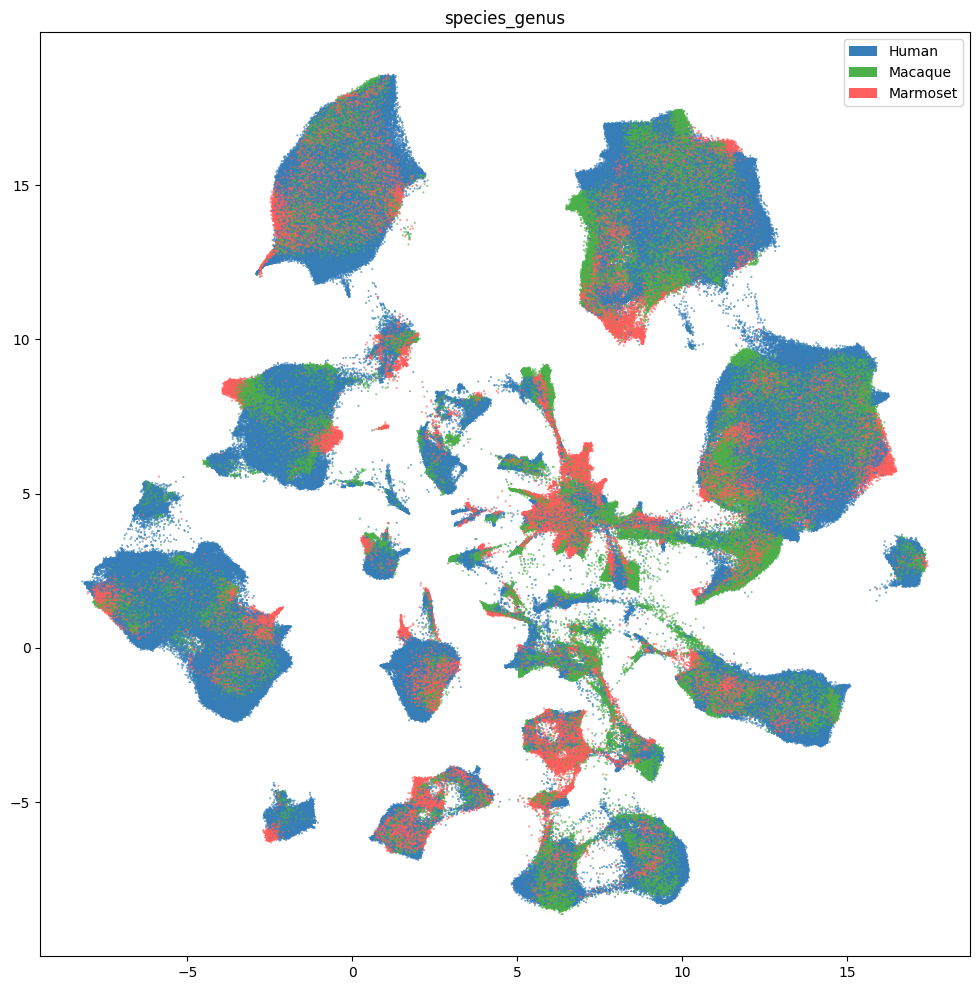

In [19]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['species_genus_color'],
    labels=cell_extended['species_genus'],
    term_orders=cell_extended['species_genus_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_genus")
plt.show()

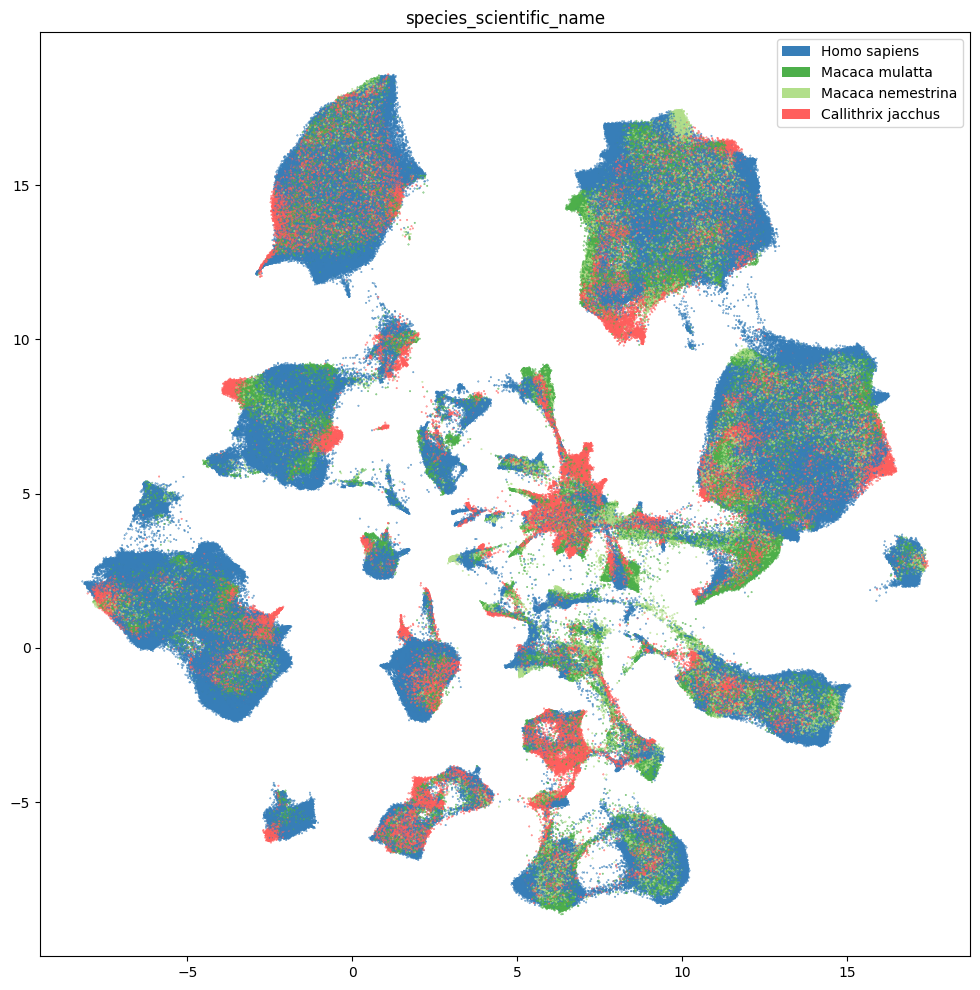

In [20]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['species_scientific_name_color'],
    labels=cell_extended['species_scientific_name'],
    term_orders=cell_extended['species_scientific_name_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_scientific_name")
plt.show()

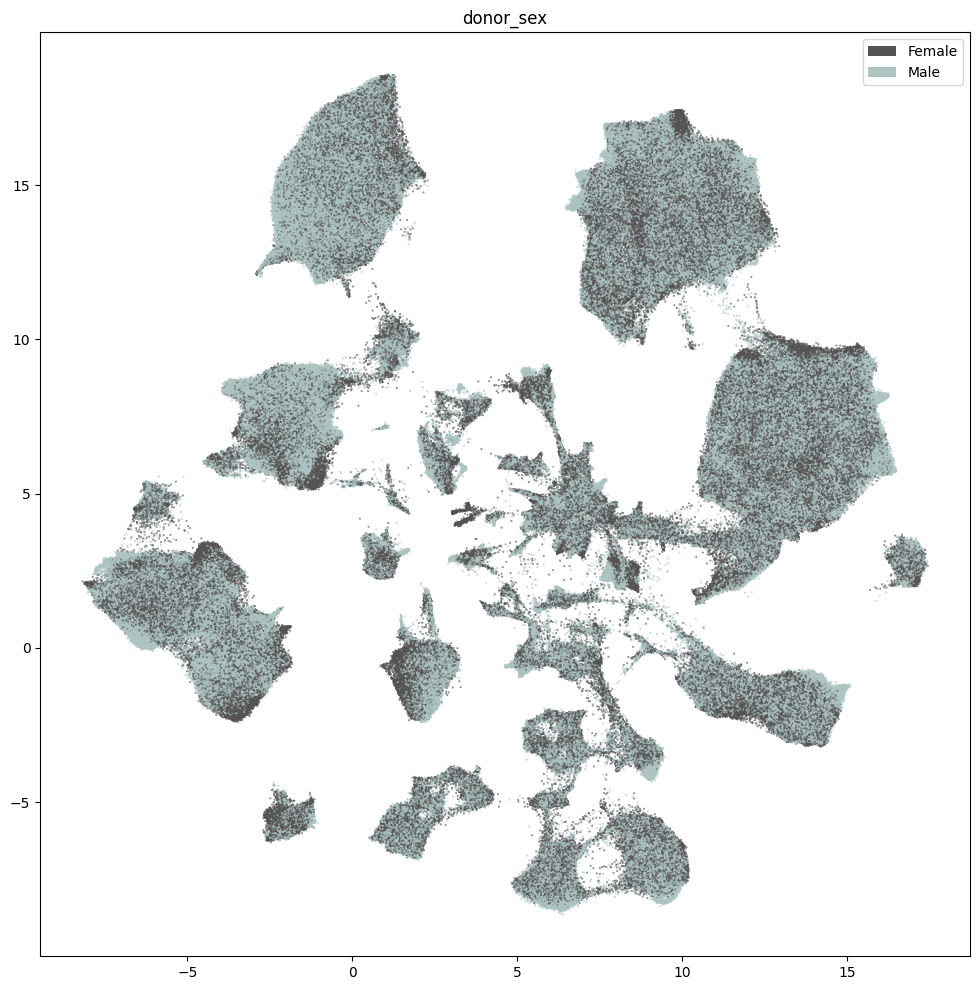

In [21]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_sex_color'],
    labels=cell_extended['donor_sex'],
    term_orders=cell_extended['donor_sex_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("donor_sex")
plt.show()

Below we show the region of interest for the three species. Note, however, that Marmoset does not have fine grained ROIs available and is marked as `Br - Brain`.

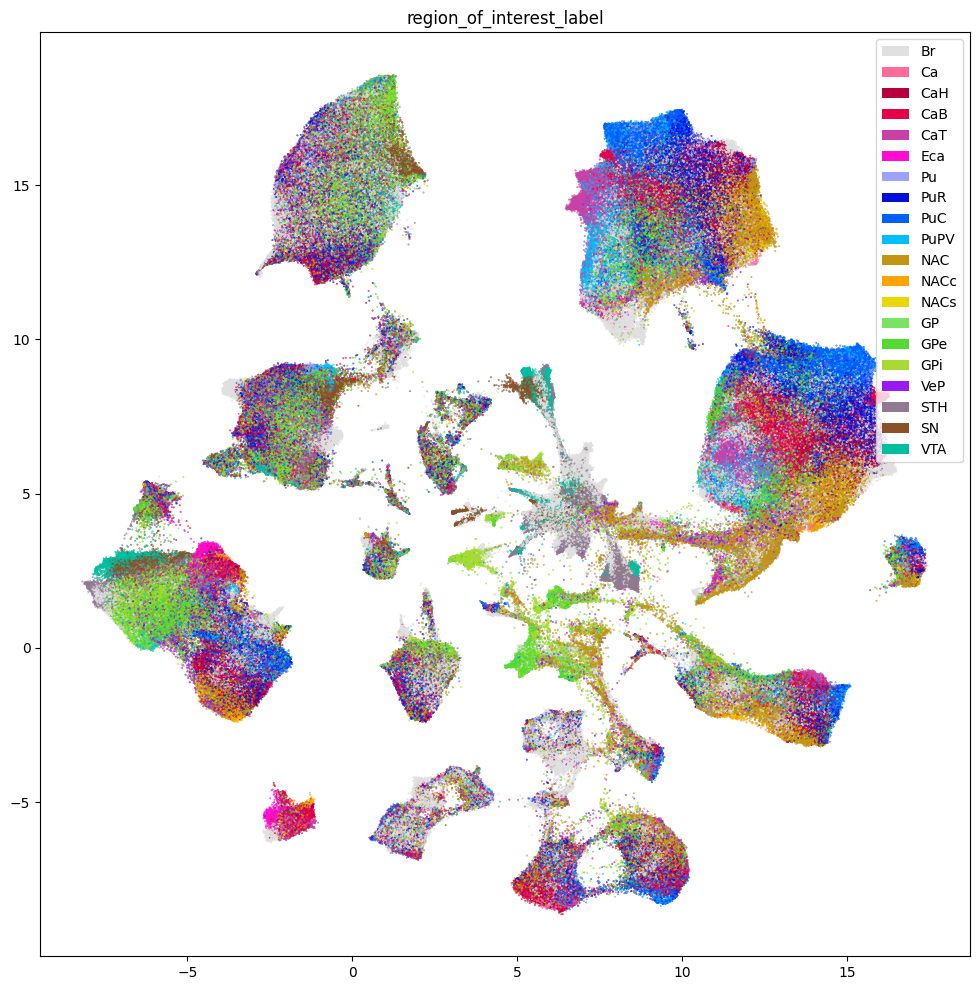

In [22]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['region_of_interest_label_color'],
    labels=cell_extended['region_of_interest_label'],
    term_orders=cell_extended['region_of_interest_label_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("region_of_interest_label")
plt.show()

## Taxonomy Information

The final set of metadata we load into our extended cell metadata file maps the cells into their assigned cluster in the taxonomy. We additionally load metadata for the clusters and compute useful information, such as the number of cells in each taxon at each level of the taxonomy.

First, we load information associated with each Cluster in the taxonomy. This includes a useful alias value for each cluster as well as the number of cells in each cluster.

In [23]:
cluster = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster',
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster.head()

cluster_alias  number_of_cells
cluster_annotation_term_label                               
CS20250428_CLUST_0161             Human-143               91
CS20250428_CLUST_0162             Human-145             1783
CS20250428_CLUST_0163             Human-146              172
CS20250428_CLUST_0164             Human-149             2649
CS20250428_CLUST_0165             Human-150             1359

Next, we load the table that describes the levels in the taxonomy from Neighborhood at the highest to Cluster at the lowest level.

In [24]:
cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})
cluster_annotation_term_set

cluster_annotation_term_label          name   description  order
0           CCN20250428_LEVEL_0  Neighborhood  Neighborhood      0
1           CCN20250428_LEVEL_1         Class         Class      1
2           CCN20250428_LEVEL_2      Subclass      Subclass      2
3           CCN20250428_LEVEL_3         Group         Group      3
4           CCN20250428_LEVEL_4       Cluster       Cluster      4

For the clusters, we load information on the annotations for each cluster. This also includes the term order and color information which we will use to plot later.

In [25]:
cluster_annotation_term = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term',
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term.head()

name  \
cluster_annotation_term_label                         
CS20250428_NEIGH_0001                     Nonneuron   
CS20250428_NEIGH_0000                Glut Sero Dopa   
CS20250428_NEIGH_0002               Subpallium GABA   
CS20250428_NEIGH_0003          Subpallium GABA-Glut   
CS20250428_CLASS_0000                    Astro-Epen   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20250428_NEIGH_0001                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0000                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0002                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0003                       CCN20250428_LEVEL_0   
CS20250428_CLASS_0000                       CCN20250428_LEVEL_1   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20250428_NEIGH_0001                             Neighborhood   
CS20250428_NEIGH_0000                             Neighborhood   
CS20250428_NEIGH_0002                             Neighborhood   
CS20250428_NEIGH_0003                             Neighborhood   
CS20250428_CLASS_0000                                    Class   

                              color_hex_triplet  term_order  term_set_order  \
cluster_annotation_term_label                                                 
CS20250428_NEIGH_0001                   #a8afa5           1               0   
CS20250428_NEIGH_0000                   #91f4bb           2               0   
CS20250428_NEIGH_0002                   #19613b           3               0   
CS20250428_NEIGH_0003                   #7e1d19           4               0   
CS20250428_CLASS_0000                   #401e66           1               1   

                                   parent_term_label parent_term_name  \
cluster_annotation_term_label                                           
CS20250428_NEIGH_0001                            NaN              NaN   
CS20250428_NEIGH_0000                            NaN              NaN   
CS20250428_NEIGH_0002                            NaN              NaN   
CS20250428_NEIGH_0003                            NaN              NaN   
CS20250428_CLASS_0000          CS20250428_NEIGH_0001        Nonneuron   

                              parent_term_set_label  
cluster_annotation_term_label                        
CS20250428_NEIGH_0001                           NaN  
CS20250428_NEIGH_0000                           NaN  
CS20250428_NEIGH_0002                           NaN  
CS20250428_NEIGH_0003                           NaN  
CS20250428_CLASS_0000           CCN20250428_LEVEL_0

Finally, we load the cluster to cluster annotation membership table. Each row in this table is a mapping between the clusters and every level of the taxonomy it belongs to, including itself. We'll use this table in a `groupby`s to allow us to count up the number of clusters at each taxonomy level and sum the number of cells in each taxon in the taxonomy a all levels.

In [26]:
cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_to_cluster_annotation_membership',
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(
    cluster.reset_index().set_index('cluster_alias')[['number_of_cells']],
    on='cluster_alias'
)
membership_with_cluster_info = membership_with_cluster_info.join(cluster_annotation_term, rsuffix='_anno_term').reset_index()
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)
membership_with_cluster_info.head()

cluster_annotation_term_label cluster_annotation_term_set_label  \
0         CS20250428_CLUST_0161               CCN20250428_LEVEL_4   
1         CS20250428_CLUST_0162               CCN20250428_LEVEL_4   
2         CS20250428_CLUST_0163               CCN20250428_LEVEL_4   
3         CS20250428_CLUST_0164               CCN20250428_LEVEL_4   
4         CS20250428_CLUST_0165               CCN20250428_LEVEL_4   

  cluster_alias cluster_annotation_term_set_name cluster_annotation_term_name  \
0     Human-143                          Cluster                    Human-143   
1     Human-145                          Cluster                    Human-145   
2     Human-146                          Cluster                    Human-146   
3     Human-149                          Cluster                    Human-149   
4     Human-150                          Cluster                    Human-150   

   number_of_cells       name cluster_annotation_term_set_label_anno_term  \
0               91  Human-143                         CCN20250428_LEVEL_4   
1             1783  Human-145                         CCN20250428_LEVEL_4   
2              172  Human-146                         CCN20250428_LEVEL_4   
3             2649  Human-149                         CCN20250428_LEVEL_4   
4             1359  Human-150                         CCN20250428_LEVEL_4   

  cluster_annotation_term_set_name_anno_term color_hex_triplet  term_order  \
0                                    Cluster           #4ac0ed           0   
1                                    Cluster           #8af851           1   
2                                    Cluster           #d1dd68           2   
3                                    Cluster           #95daf6           3   
4                                    Cluster           #26827e           4   

   term_set_order      parent_term_label parent_term_name  \
0               4  CS20250428_GROUP_0039        Astrocyte   
1               4  CS20250428_GROUP_0039        Astrocyte   
2               4  CS20250428_GROUP_0039        Astrocyte   
3               4  CS20250428_GROUP_0039        Astrocyte   
4               4  CS20250428_GROUP_0039        Astrocyte   

  parent_term_set_label  
0   CCN20250428_LEVEL_3  
1   CCN20250428_LEVEL_3  
2   CCN20250428_LEVEL_3  
3   CCN20250428_LEVEL_3  
4   CCN20250428_LEVEL_3

From the membership table, we create three tables via a `groupby`. First the name of each cluster and its parents.

In [27]:
# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[cluster_annotation_term_set['name']] # order columns
cluster_details.fillna('Other', inplace=True)
cluster_details.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_details.head()

cluster_annotation_term_set_name    Neighborhood     Class Subclass  \
cluster_alias                                                         
Human-128                         Glut Sero Dopa  F M Glut   F Glut   
Human-129                         Glut Sero Dopa  F M Glut   F Glut   
Human-130                         Glut Sero Dopa  F M Glut   F Glut   
Human-423                         Glut Sero Dopa  F M Glut   F Glut   
Human-426                         Glut Sero Dopa  F M Glut   F Glut   

cluster_annotation_term_set_name          Group    Cluster  
cluster_alias                                               
Human-128                         BF SKOR1 Glut  Human-128  
Human-129                         BF SKOR1 Glut  Human-129  
Human-130                         BF SKOR1 Glut  Human-130  
Human-423                         BF SKOR1 Glut  Human-423  
Human-426                         BF SKOR1 Glut  Human-426

Next the plotting order of each of the clusters and their parents.

In [28]:
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)
cluster_order.head()

cluster_annotation_term_set_name  Class_order  Cluster_order  Group_order  \
cluster_alias                                                               
Human-143                                   1              0            1   
Human-145                                   1              1            1   
Human-146                                   1              2            1   
Human-149                                   1              3            1   
Human-150                                   1              4            1   

cluster_annotation_term_set_name  Neighborhood_order  Subclass_order  
cluster_alias                                                         
Human-143                                          1               1  
Human-145                                          1               1  
Human-146                                          1               1  
Human-149                                          1               1  
Human-150                                          1               1

Finally, the colors we will use to plot for each of the unique taxons at all levels.

In [29]:
cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_colors.head()

cluster_annotation_term_set_name Neighborhood    Class Subclass    Group  \
cluster_alias                                                              
Marmoset-323                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-307                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-325                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Human-346                             #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-301                          #19613b  #26e8bb  #1bc06a  #fc2b80   

cluster_annotation_term_set_name  Cluster  
cluster_alias                              
Marmoset-323                      #00d86e  
Marmoset-307                      #0454b2  
Marmoset-325                      #094a6f  
Human-346                         #0f6331  
Marmoset-301                      #1140be

Next, we bring it all together by loading the mapping of cells to cluster and join into our final metadata table. Note here that not every cell is currently associated into the taxonomy hence the NaN values for many of the taxonomy information columns.

In [30]:
cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_to_cluster_membership',
).set_index('cell_label')
cell_to_cluster_membership.head()

cluster_alias          cluster_label
cell_label                                                    
AAACAGCCAAATGCCC-2362_A05     Human-451  CS20250428_CLUST_0268
AAACAGCCAATTGAGA-2362_A05       Human-1  CS20250428_CLUST_0227
AAACAGCCAGCATGTC-2362_A05     Human-153  CS20250428_CLUST_0215
AAACAGCCATTGACAT-2362_A05       Human-1  CS20250428_CLUST_0227
AAACAGCCATTGTGGC-2362_A05      Human-14  CS20250428_CLUST_0249

We merge this table with information from our clusters. Note again that not all clusters are associated into the taxonomy hence we use an left join here to use only those clusters with annotations. These un-annotated clusters are in part what make up the Adjacent taxons described in [HMBA-BG spatial notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_spatial_slabs_and_taxonomy.html).

In [31]:
cell_extended = cell_extended.join(cell_to_cluster_membership, rsuffix='_cell_to_cluster_membership')
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')

del cell_to_cluster_membership

cell_extended.head()

cell_barcode donor_label  \
cell_label                                                
TTAGTCAAGGGTCTAT-2526_D01  TTAGTCAAGGGTCTAT  H24.30.007   
TATTGACCAATCCTAG-810_D02   TATTGACCAATCCTAG  Q19.26.010   
TTAGCAGGTTGAATCG-810_F02   TTAGCAGGTTGAATCG  Q21.26.002   
GGGTTATTCGGTTTCC-2013_B01  GGGTTATTCGGTTTCC  H23.30.001   
CTACGAAGTCGCAAAC-936_C03   CTACGAAGTCGCAAAC  Q21.26.002   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
TTAGTCAAGGGTCTAT-2526_D01                   2526_D01  L8XR_241031_21_B03   
TATTGACCAATCCTAG-810_D02                     810_D02  L8XR_210909_02_A09   
TTAGCAGGTTGAATCG-810_F02                     810_F02  L8XR_210909_02_C09   
GGGTTATTCGGTTTCC-2013_B01                   2013_B01  L8XR_240111_01_A09   
CTACGAAGTCGCAAAC-936_C03                     936_C03  L8XR_211118_02_C04   

                                                   alignment_job_id  \
cell_label                                                            
TTAGTCAAGGGTCTAT-2526_D01  c8ef9f604a1f521e81fff7c2734fff38e2961c99   
TATTGACCAATCCTAG-810_D02   f8ecabad76cba4ea3f27a3ad40407e5901031b6e   
TTAGCAGGTTGAATCG-810_F02   24ff39ab46f5096da374d868feac405470ae60ab   
GGGTTATTCGGTTTCC-2013_B01  4ab5f6ecc6d6d33becb6d779f2eb2827070e7de8   
CTACGAAGTCGCAAAC-936_C03   44c17a26ca9c6f204075ddc6f10e1029fdcea4c5   

                           doublet_score  umi_count  \
cell_label                                            
TTAGTCAAGGGTCTAT-2526_D01       0.160000     3297.0   
TATTGACCAATCCTAG-810_D02        0.000000    15171.0   
TTAGCAGGTTGAATCG-810_F02        0.000000    14517.0   
GGGTTATTCGGTTTCC-2013_B01       0.029412     2534.0   
CTACGAAGTCGCAAAC-936_C03        0.000000     8018.0   

                                  feature_matrix_label  \
cell_label                                               
TTAGTCAAGGGTCTAT-2526_D01  HMBA-10xMultiome-BG-Aligned   
TATTGACCAATCCTAG-810_D02   HMBA-10xMultiome-BG-Aligned   
TTAGCAGGTTGAATCG-810_F02   HMBA-10xMultiome-BG-Aligned   
GGGTTATTCGGTTTCC-2013_B01  HMBA-10xMultiome-BG-Aligned   
CTACGAAGTCGCAAAC-936_C03   HMBA-10xMultiome-BG-Aligned   

                                         dataset_label  \
cell_label                                               
TTAGTCAAGGGTCTAT-2526_D01  HMBA-10xMultiome-BG-Aligned   
TATTGACCAATCCTAG-810_D02   HMBA-10xMultiome-BG-Aligned   
TTAGCAGGTTGAATCG-810_F02   HMBA-10xMultiome-BG-Aligned   
GGGTTATTCGGTTTCC-2013_B01  HMBA-10xMultiome-BG-Aligned   
CTACGAAGTCGCAAAC-936_C03   HMBA-10xMultiome-BG-Aligned   

                                                  abc_sample_id  ...  \
cell_label                                                       ...   
TTAGTCAAGGGTCTAT-2526_D01  6175804c-370f-47b4-b42d-765efad5f6d7  ...   
TATTGACCAATCCTAG-810_D02   fdd9fc57-897b-4108-abf4-aa0f27831836  ...   
TTAGCAGGTTGAATCG-810_F02   89434f36-72d3-410a-b462-aed5f931d02b  ...   
GGGTTATTCGGTTTCC-2013_B01  70d5cd7f-85c0-49a1-a72e-9c5f8d311322  ...   
CTACGAAGTCGCAAAC-936_C03   4a771527-887b-4a14-b45c-5c776239be14  ...   

                          Neighborhood_color Class_color Subclass_color  \
cell_label                                                                
TTAGTCAAGGGTCTAT-2526_D01            #a8afa5     #401e66        #401e66   
TATTGACCAATCCTAG-810_D02             #19613b     #d0b83c        #1655f2   
TTAGCAGGTTGAATCG-810_F02             #19613b     #d0b83c        #79bdf4   
GGGTTATTCGGTTTCC-2013_B01            #a8afa5     #995C60        #995C60   
CTACGAAGTCGCAAAC-936_C03             #19613b     #d0b83c        #1655f2   

                          Group_color Cluster_color  Class_order  \
cell_label                                                         
TTAGTCAAGGGTCTAT-2526_D01     #195f8d       #b1063e            1   
TATTGACCAATCCTAG-810_D02      #1f77b4       #512782           10   
TTAGCAGGTTGAATCG-810_F02      #9467bd       #df2c0d           10   
GGGTTATTCGGTTTC

In [32]:
print_column_info(cell_extended)

Number of unique cell_barcode = 680274 
Number of unique donor_label = 22 ['CJ23.56.002', 'CJ23.56.003', 'CJ24.56.001', 'CJ24.56.004', 'H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 417 
Number of unique library_label = 417 
Number of unique alignment_job_id = 303 
Number of unique doublet_score = 1422 
Number of unique umi_count = 85704 
Number of unique feature_matrix_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique abc_sample_id = 1863243 
Number of unique donor_species = 4 ['NCBITaxon:9483', 'NCBITaxon:9544', 'NCBITaxon:9545', 'NCBITaxon:9606']
Number of unique species_scientific_name = 4 ['Callithrix jacchus', 'Homo sapiens', 'Macaca mulatta', 'Macaca ne

#### Plotting the taxonomy

Now that we have our cells with associated taxonomy information, we'll plot them into the UMAP we showed previously.

Below we plot the taxonomy mapping of the cells for each level in the taxonomy.

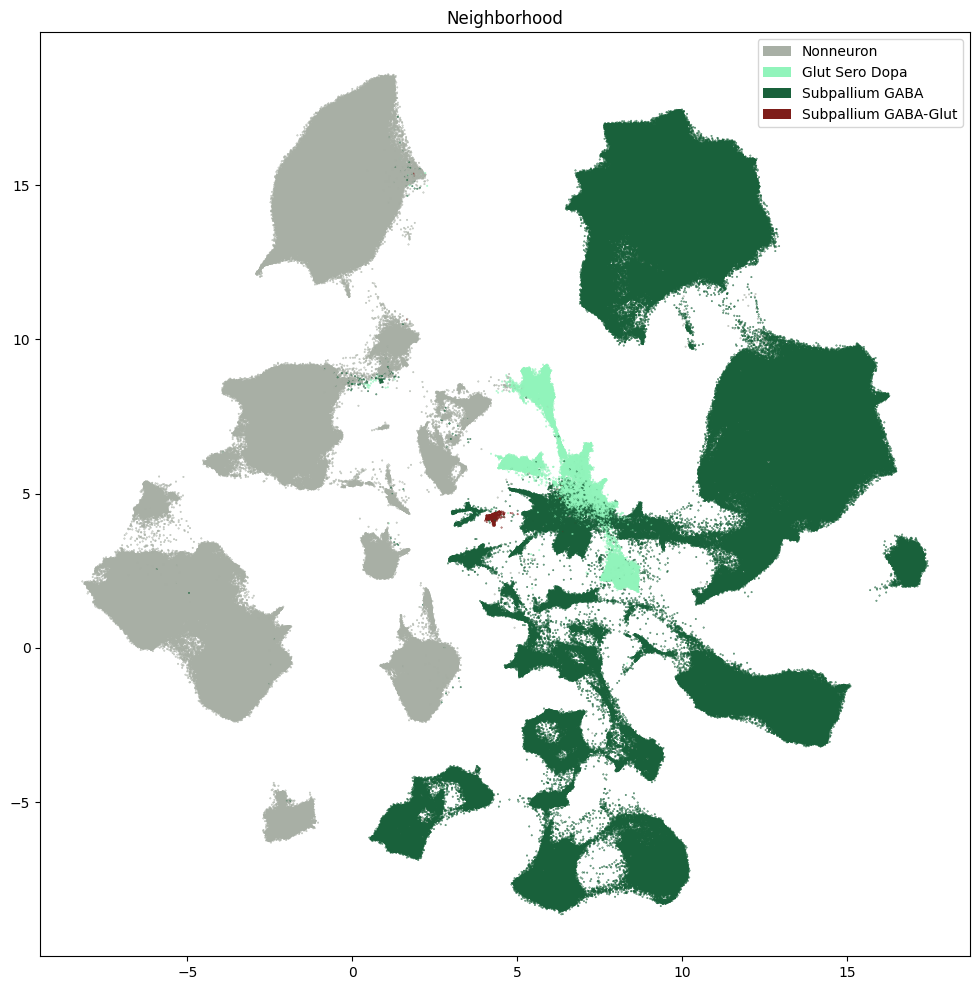

In [33]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Neighborhood_color'],
    labels=cell_extended['Neighborhood'],
    term_orders=cell_extended['Neighborhood_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Neighborhood")
plt.show()

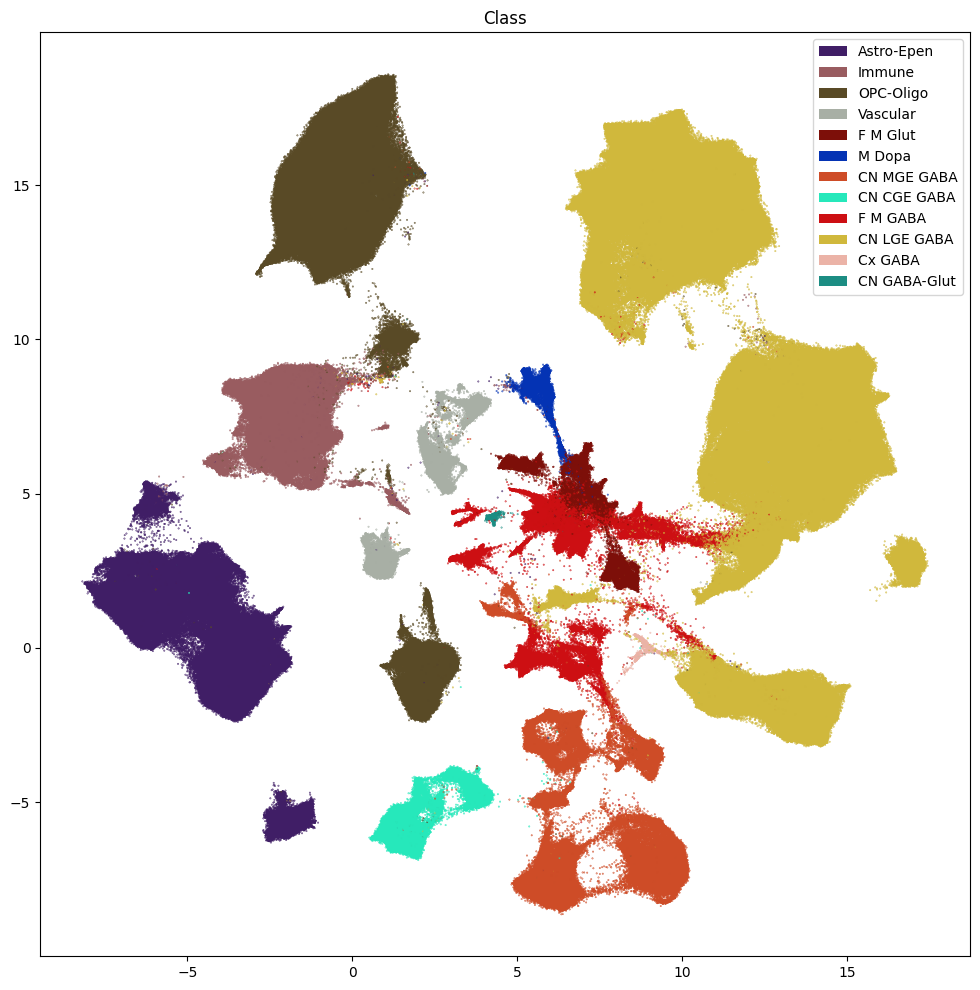

In [34]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Class_color'],
    labels=cell_extended['Class'],
    term_orders=cell_extended['Class_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Class")
plt.show()

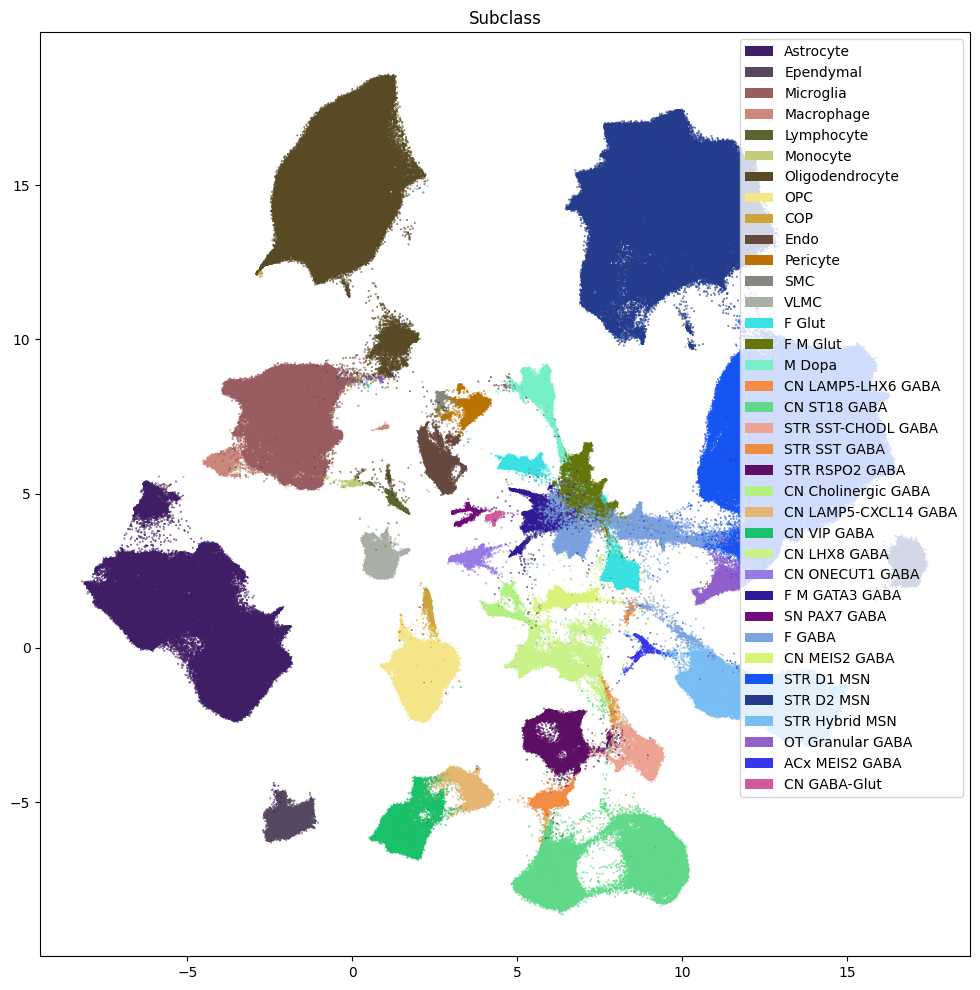

In [35]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Subclass_color'],
    labels=cell_extended['Subclass'],
    term_orders=cell_extended['Subclass_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Subclass")
plt.show()

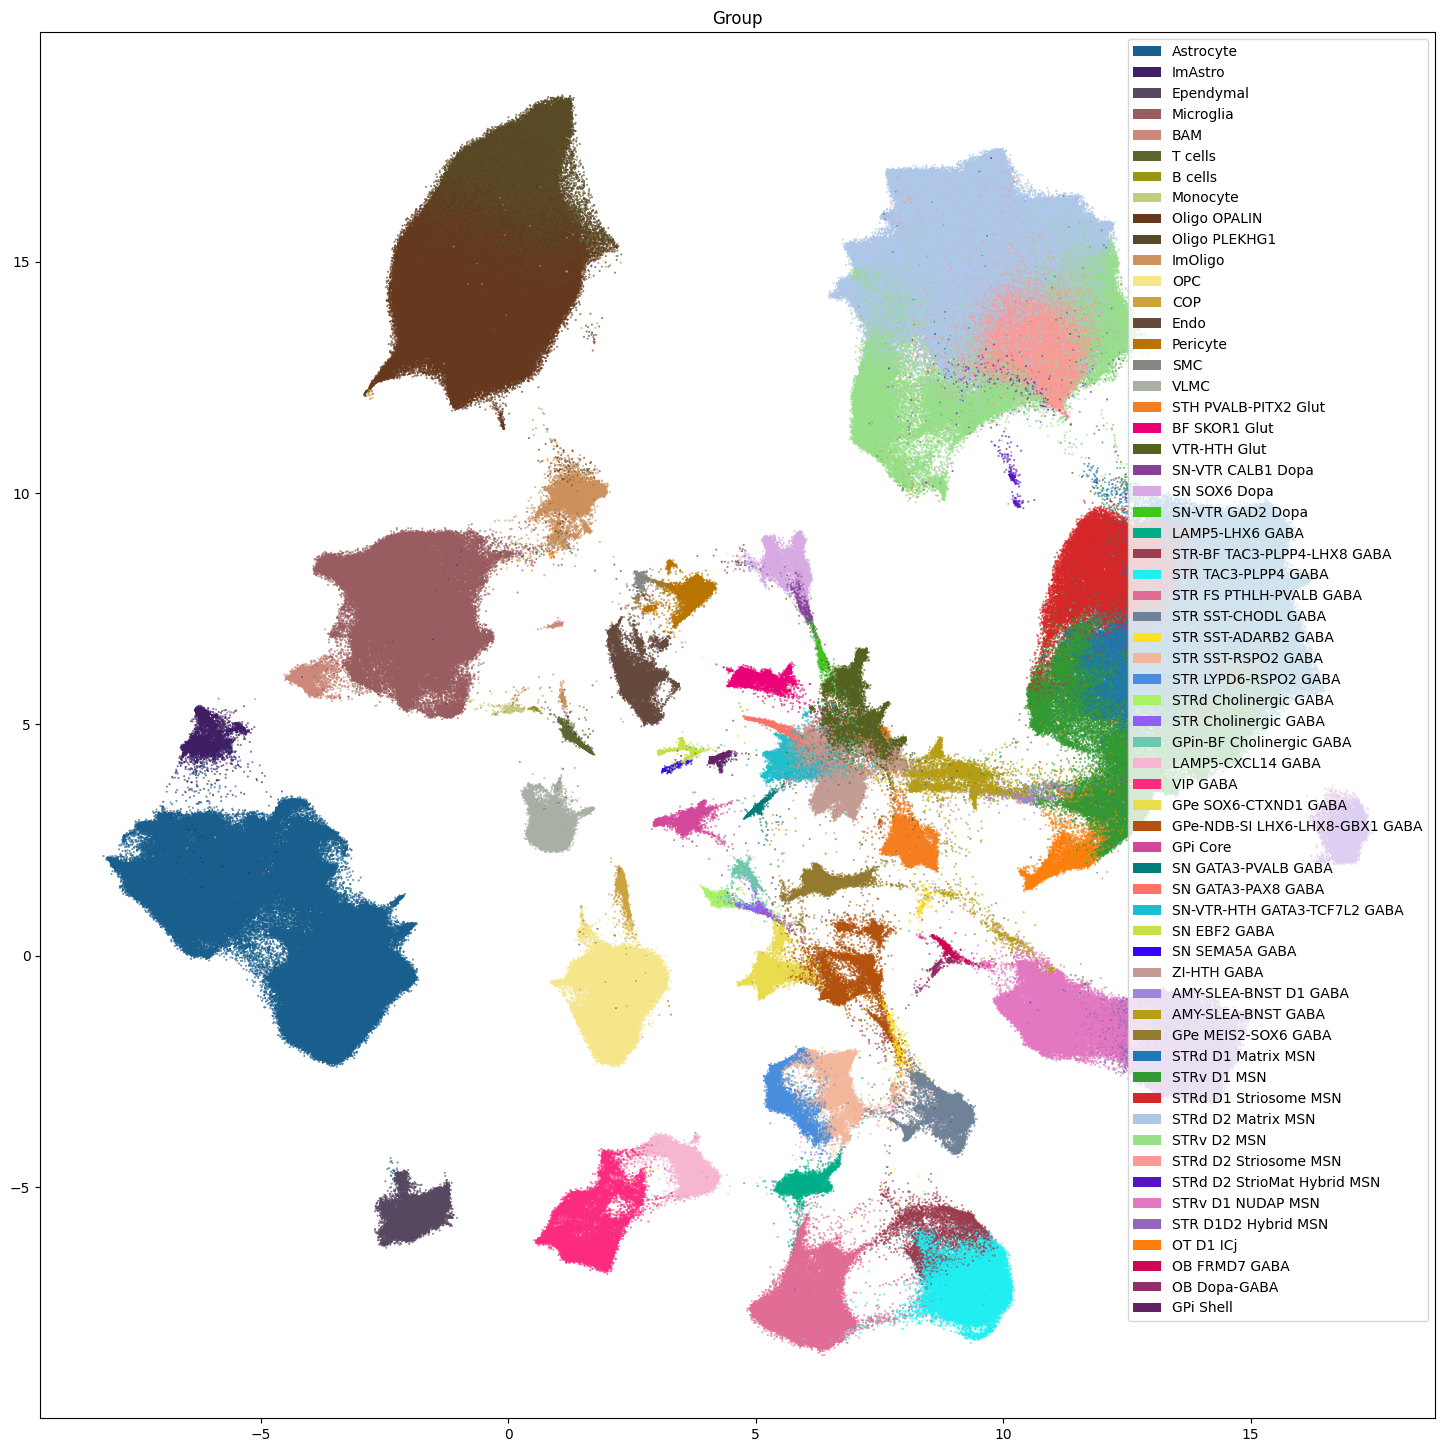

In [36]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Group_color'],
    labels=cell_extended['Group'],
    term_orders=cell_extended['Group_order'],
    fig_width=18,
    fig_height=18
)
res = ax.set_title("Group")
plt.show()

Note that we do not plot the cluster level here. Comparison of the clusters across species is not recommended and any cross species analysis should use the Group level at the lowest. Clusters should only be used when looking at individual species as we do below.

### Aggregating cluster and cells counts per term per species.

Let's investigate the taxonomy information a bit more. In this section, we'll create bar plots showing the number of clusters and cells at each level in the taxonomy. We do this on a per-species basis as the number of clusters and cells as between species comparisons of clusters is not recommended.

First, we need to compute the number of clusters that are in each of the cell type taxons above it. We do this for each species.

In [37]:
# Count the number of clusters associated with each cluster annotation term

species_term_with_counts = {}
for species in  ['Human', 'Macaque', 'Marmoset', 'All']:
    if species == 'All':
        species_mask = np.ones(len(membership_with_cluster_info), dtype=bool)
    else:
        species_mask = membership_with_cluster_info['cluster_alias'].str.startswith(species)

    term_cluster_count = membership_with_cluster_info[species_mask].reset_index().groupby(
        ['cluster_annotation_term_label']
    )[['cluster_alias']].count()
    term_cluster_count.columns = ['number_of_clusters']

    term_cell_count = membership_with_cluster_info[species_mask].reset_index().groupby(
        ['cluster_annotation_term_label']
    )[['number_of_cells']].sum()
    term_cell_count.columns = ['number_of_cells']

    term_with_counts = cluster_annotation_term.join(term_cluster_count)
    term_with_counts = term_with_counts.join(term_cell_count)

    species_term_with_counts[species] = term_with_counts[~pd.isna(term_with_counts.number_of_cells)]

Below we create a function to plot the cluster and cell counts in a bar graph, coloring by the associated taxon level.

In [38]:
def bar_plot_by_level_and_type(df: pd.DataFrame, level: str, fig_width: float = 8.5, fig_height: float = 4):
    """Plot the number of cells by the specified level.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cluster annotation terms with counts.
    level : str
        The level of the taxonomy to plot (e.g., 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster').
    fig_width : float, optional
        Width of the figure in inches. Default is 8.5.
    fig_height : float, optional
        Height of the figure in inches. Default is 4.
    """

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(fig_width, fig_height)

    for idx, ctype in enumerate(['clusters', 'cells']):

        pred = (df['cluster_annotation_term_set_name'] == level)
        sort_order = np.argsort(df[pred]['term_order'])
        names = df[pred]['name'].iloc[sort_order]
        counts = df[pred]['number_of_%s' % ctype].iloc[sort_order]
        colors = df[pred]['color_hex_triplet'].iloc[sort_order]
        
        ax[idx].barh(names, counts, color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype,level))
        ax[idx].set_xlabel('Number of %s' % ctype)
        if ctype == 'cells':
            ax[idx].set_xscale('log')
        
        if idx > 0:
            ax[idx].set_yticklabels([])

    return fig, ax

Now let's plot the counts for each of the taxonomy levels above Cluster.

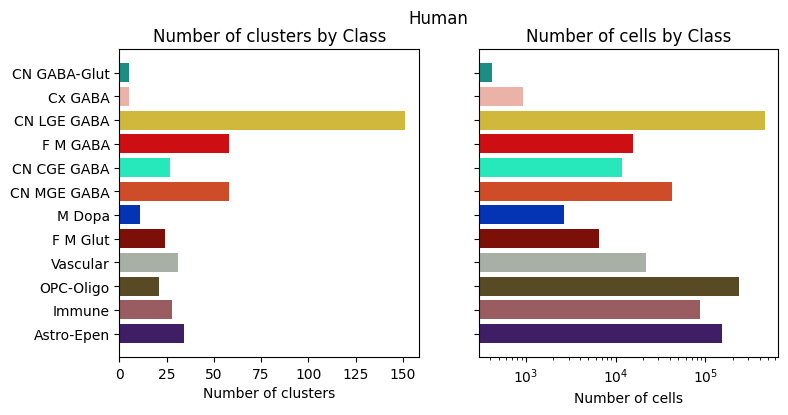

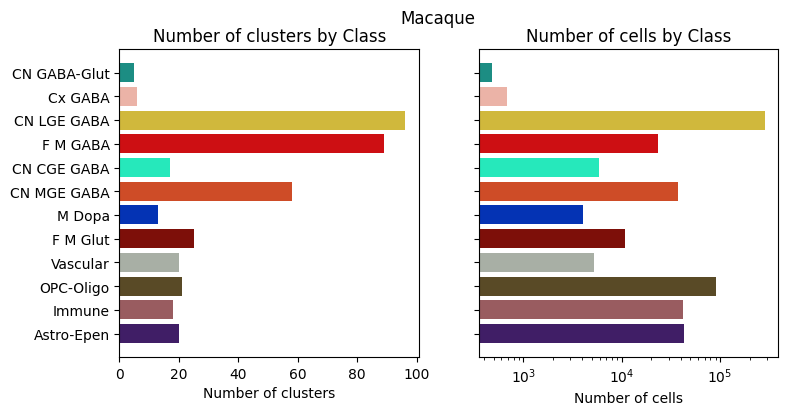

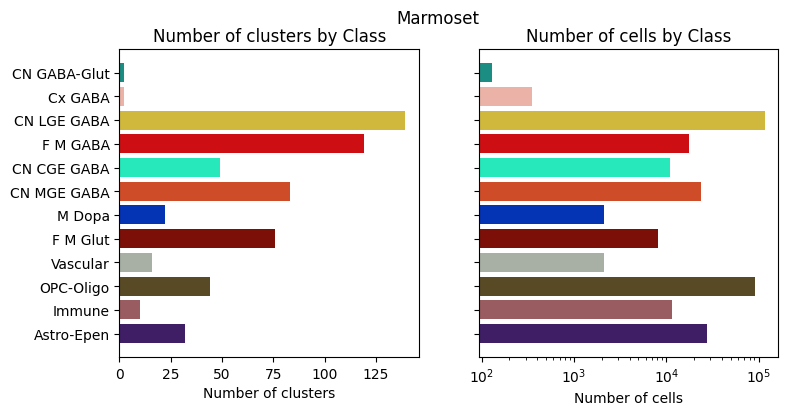

In [39]:
for species in ['Human', 'Macaque', 'Marmoset']:
    fig, ax = bar_plot_by_level_and_type(species_term_with_counts[species], 'Class')
    fig.suptitle(f"{species}")
    plt.show()

### Visualizing the BG taxonomy

Term sets: Neighborhood, Class, Subclass, and Group define the cross-species taxonomy. We can visualize the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the Neighborhood level. Rings are divided based on their hierarchical relationship to the parent slice. We use the number of cells in each taxon to define the angle of the taxon in the sunburst diagram.

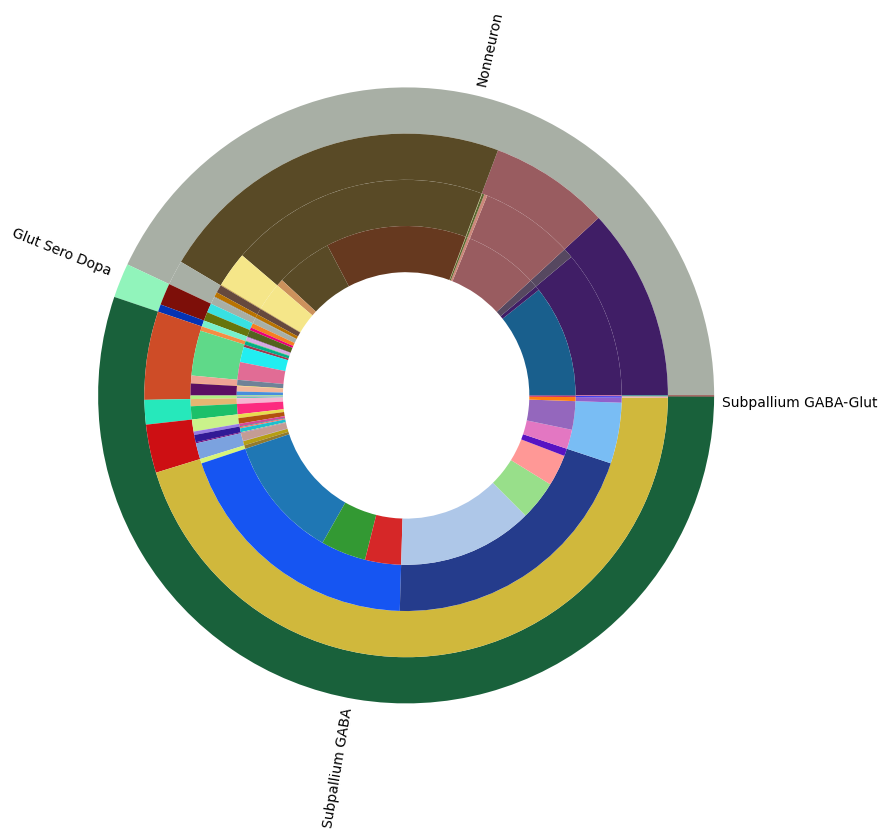

In [40]:
levels = ['Neighborhood', 'Class', 'Subclass', 'Group']
df = {}

# Copy the term order of the parent into each of the level below it.
all_term_with_counts = species_term_with_counts['All']
all_term_with_counts['parent_order'] = ""
for idx, row in all_term_with_counts.iterrows():
    if pd.isna(row['parent_term_label']):
        continue
    all_term_with_counts.loc[idx, 'parent_order'] = all_term_with_counts.loc[row['parent_term_label']]['term_order']

all_term_with_counts = all_term_with_counts.reset_index()
for lvl in levels:
    pred = all_term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = all_term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_order', 'term_order'])

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
size = 0.15

for i, lvl in enumerate(levels):
    
    if lvl == 'Neighborhood':
        ax.pie(df[lvl]['number_of_cells'],
               colors=df[lvl]['color_hex_triplet'],
               labels = df[lvl]['name'],
               rotatelabels=True,
               labeldistance=1.025,
               radius=1,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
    else :
        ax.pie(df[lvl]['number_of_cells'],
               colors=df[lvl]['color_hex_triplet'],
               radius=1-i*size,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
all_term_with_counts.set_index('cluster_annotation_term_label', inplace=True)
plt.show()

In the next tutorial, we show how to access and use [HMBA-BG gene expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_10X_snRNASeq_tutorial.html).

To see how this taxonomy can is used in spatial transcriptomic data, see the take look at the [HBMA-BG Spatial Slabs and Taxonomy notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_spatial_slabs_and_taxonomy.html).